<img src='https://repository-images.githubusercontent.com/121802384/c355bb80-7d42-11e9-9e0e-4729609f9fbc' alt='WRF-Hydro Logo' width="15%"/>

# Lesson 6 - Lake options for the gridded configuration

## Overview
In [Lesson 4](Lesson-4-run-options.ipynb) we covered some experiments in tinkering with terrain physics. In this lesson, we specifically experiment with lake physics options. 

We conduct two experiments in this lesson: 

1. Removing lakes from the simulation
2. Modifying lake parameters

See [here](https://ral.ucar.edu/sites/default/files/public/Channel%20Routing_Lakes.pdf) for reference material on lakes and channel routing in WRF-Hydro.

### Compiling WRF-Hydro
We do not need to modify the code binary to conduct lake physics experiments, so we will use the compiled code from the template directory.  

If you need to recompile the code, refer to the instructions in [Lesson 2](Lesson-2-run.ipynb).

### Creating the simulation directory and running a baseline WRF-Hydro simulation
Below are the commands from Lesson 2 to create the simulation directory and run a WRF-Hydro simulation. This simulation will be run exactly as was done in Lesson 2 and will serve as our baseline simulation. We will modify run-time options in subsequent simulations in the lesson and compare the outputs.  

In [10]:
%%bash

# Make a new directory for our baseline simulation
rm -rf ~/wrf-hydro-training/output/lesson6/run_gridded_baseline
mkdir -p ~/wrf-hydro-training/output/lesson6/run_gridded_baseline

# Copy our model files to the simulation directory
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/build/Run/*.TBL \
  ~/wrf-hydro-training/output/lesson6/run_gridded_baseline
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/build/Run/wrf_hydro \
  ~/wrf-hydro-training/output/lesson6/run_gridded_baseline

# Create symbolic links to large domain files
cp -as $HOME/wrf-hydro-training/example_case/FORCING \
  ~/wrf-hydro-training/output/lesson6/run_gridded_baseline
cp -as $HOME/wrf-hydro-training/example_case/Gridded/DOMAIN \
  ~/wrf-hydro-training/output/lesson6/run_gridded_baseline
cp -as $HOME/wrf-hydro-training/example_case/Gridded/RESTART \
  ~/wrf-hydro-training/output/lesson6/run_gridded_baseline

# Copy namelist files
cp ~/wrf-hydro-training/example_case/Gridded/namelist.hrldas \
  ~/wrf-hydro-training/output/lesson6/run_gridded_baseline
cp ~/wrf-hydro-training/example_case/Gridded/hydro.namelist \
  ~/wrf-hydro-training/output/lesson6/run_gridded_baseline

**Run the simulation**

In [11]:
%%bash
cd ~/wrf-hydro-training/output/lesson6/run_gridded_baseline
mpirun -np 2 ./wrf_hydro &> run.log

In [12]:
%%bash
cd ~/wrf-hydro-training/output/lesson6/run_gridded_baseline

In [13]:
%%bash

# Check that it finished successfully
tail -1 ~/wrf-hydro-training/output/lesson6/run_gridded_baseline/diag_hydro.00000

 The model finished successfully.......


## Setup for experiments

We will create a new simulation directory for each experiment. First, we will make a new simulation directory as we did with the baseline run above and use this as a template for creating multiple new simulation directories.

**Step 1: Create a simulation directory to use as a template**

In [14]:
%%bash

# Make a new directory for our baseline simulation
rm -rf ~/wrf-hydro-training/output/lesson6/run_gridded_template
mkdir -p ~/wrf-hydro-training/output/lesson6/run_gridded_template

# Copy our model files to the simulation directory
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/build/Run/*.TBL \
  ~/wrf-hydro-training/output/lesson6/run_gridded_template
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/build/Run/wrf_hydro \
  ~/wrf-hydro-training/output/lesson6/run_gridded_template

# Create symbolic links to large domain files
cp -as $HOME/wrf-hydro-training/example_case/FORCING \
  ~/wrf-hydro-training/output/lesson6/run_gridded_template
cp -as $HOME/wrf-hydro-training/example_case/Gridded/DOMAIN \
  ~/wrf-hydro-training/output/lesson6/run_gridded_template
cp -as $HOME/wrf-hydro-training/example_case/Gridded/RESTART \
  ~/wrf-hydro-training/output/lesson6/run_gridded_template

# Copy namelist files
cp ~/wrf-hydro-training/example_case/Gridded/namelist.hrldas \
  ~/wrf-hydro-training/output/lesson6/run_gridded_template
cp ~/wrf-hydro-training/example_case/Gridded/hydro.namelist \
  ~/wrf-hydro-training/output/lesson6/run_gridded_template

**Step 2: View the contents**

In [15]:
%%bash

ls ~/wrf-hydro-training/output/lesson6/run_gridded_template

CHANPARM.TBL
DOMAIN
FORCING
GENPARM.TBL
HYDRO.TBL
MPTABLE.TBL
RESTART
SOILPARM.TBL
hydro.namelist
namelist.hrldas
wrf_hydro


melist.hrldas
wrf_hydro


### Review the baseline
First, we will recall the hydrograph from location below the lake, at the outlet of the basin: 

In [16]:
# Load the required libraries
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

xr.set_options(display_style="html")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [17]:
chanobs_baseline = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson6/run_gridded_baseline/*CHANOBS*',
                            combine='by_coords')
obs = pd.read_csv('/home/docker/wrf-hydro-training/example_case/USGS_obs.csv',dtype=str)
obs['dateTime'] = pd.to_datetime(obs['dateTime'])
obs['streamflow_cms'] = pd.to_numeric(obs['streamflow_cms'])

**Plot the default hydrograph at the stream location downstream of the lake**

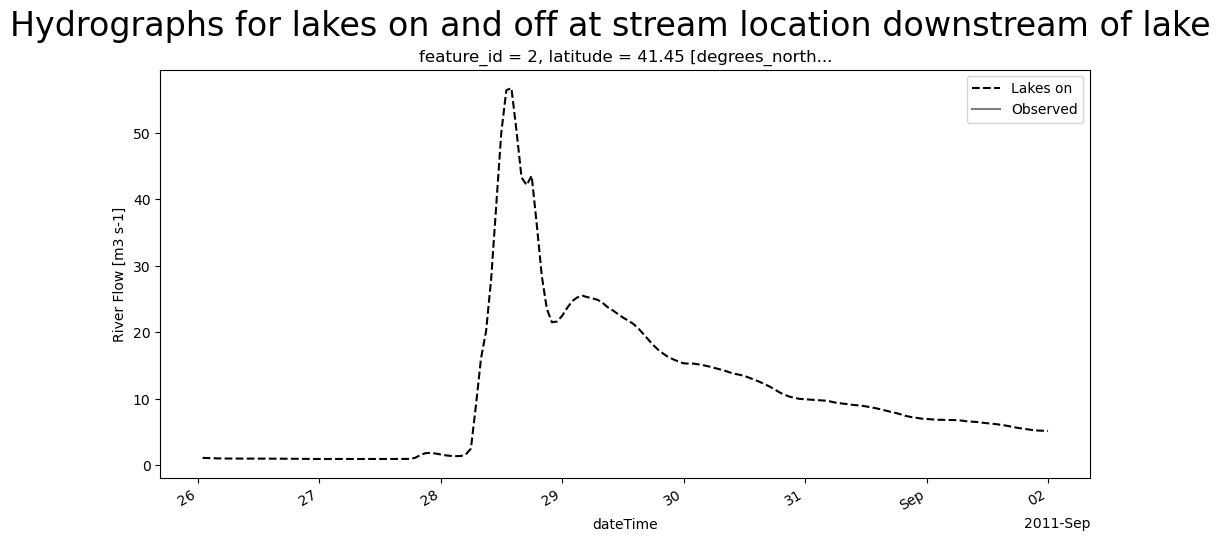

In [18]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs for lakes on and off at stream location downstream of lake',fontsize=24)
chanobs_baseline.sel(feature_id = 2).streamflow.plot(label='Lakes on',
                                                        color='black',
                                                        linestyle='--')
obs[obs['site_no'] == '01447720'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.legend()
plt.show()

From this default simulation, we have some work to do for improving the lake's representation.  First, let's see what happens when the lake is removed completely.

## Experiment 1 - Removing lakes from the simulation

### Background
In the gridded channel routing configuration, WRF-Hydro can be run with lakes on or off. 

**However, it is not as simple as flipping a switch** because in the gridded configuration, the lakes are explicitly represented on the fine grid (i.e. in the `LAKEGRID` variable in the `Fulldom_hires.nc` file).  This is different from how lakes are represented in reach-based routing, where lakes are represented as objects connected by channel reaches, rather than explicitly defined on the grid. Therefore, if a user wants to run the gridded routing configuration without lakes, they should run the GIS pre-processing tools and NOT specify a lake polygon file. This will create a `Fulldom_hires.nc` file with the LAKEGRID variable = -9999 (fill values). 

**Thus, we recommend that users setup two different domain directories to run with and without lakes, as is demonstrated in this training.**  

The only other changes to execute with and without lakes are edits in the `hydro.namelist`. See below for details.

### Objective
Run a simulation for the Gridded configuration without representing lakes and compare the resulting hydrographs at a gage downstream of the lake. 

### Create experiment simulation directory
Note, we **WILL NOT** be able to use our `run_gridded_template` directory for this experiment because we have to use different geospatial data. These data are provided for you in the `example_case/Gridded_no_lakes` directory.

In [19]:
%%bash

# Make a new directory for our baseline simulation
rm -rf ~/wrf-hydro-training/output/lesson6/run_lakes_off
mkdir -p ~/wrf-hydro-training/output/lesson6/run_lakes_off

# Copy our model files to the simulation directory
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/build/Run/*.TBL \
  ~/wrf-hydro-training/output/lesson6/run_lakes_off
cp ~/wrf-hydro-training/wrf_hydro_nwm_public/build/Run/wrf_hydro \
  ~/wrf-hydro-training/output/lesson6/run_lakes_off

# Create symbolic links to large domain files
cp -as $HOME/wrf-hydro-training/example_case/FORCING \
  ~/wrf-hydro-training/output/lesson6/run_lakes_off
cp -as $HOME/wrf-hydro-training/example_case/Gridded_no_lakes/DOMAIN \
  ~/wrf-hydro-training/output/lesson6/run_lakes_off
cp -as $HOME/wrf-hydro-training/example_case/Gridded_no_lakes/RESTART \
  ~/wrf-hydro-training/output/lesson6/run_lakes_off

# Copy namelist files
cp ~/wrf-hydro-training/example_case/Gridded_no_lakes/namelist.hrldas \
  ~/wrf-hydro-training/output/lesson6/run_lakes_off
cp ~/wrf-hydro-training/example_case/Gridded_no_lakes/hydro.namelist \
  ~/wrf-hydro-training/output/lesson6/run_lakes_off

### Review the differences and run the simulation

**Step 1: Check that the `Fulldom_hires.nc` file in the `Gridded` dir has a lake, i.e. the value of 1 occurs on the grid.**

You can use ncdump to check the values of the LAKEGRID variable. On your home machine, using a program like ncview or panoply is an easy way to visually check these values. 

In [20]:
%%bash

ncdump -v LAKEGRID ~/wrf-hydro-training/output/lesson6/run_gridded_template/DOMAIN/Fulldom_hires.nc | tail -300

    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999,

-9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
   

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
  

  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
 

   -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
 

   -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
   

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, 1

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, 
    -9999, 1, 1, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, 1, 1, 1, 1, 

-9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, 1, 1, 1, 1, 1, 1, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9

999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
 

   -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, 1, 1, 1, 1, 1, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, 1, 

1, 1, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -99

99, -9999, -9999, -9999, -9999, -9999, 1, 1, 1, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 1, 1, 1, 1, 
    -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, 1, 1, 1, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, 1, 1, 1, 1, 
    -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 1, 1, -9999, 
    -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, 1, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 1, 1, -9999, 
    -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, 1, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, 1, -9999, 
    -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
   

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999 ;
}


Run the same command on the original `Fulldom_hires.nc` file in the `Gridded_no_lakes` directory to show there are no lake values (1's)

In [21]:
%%bash

ncdump -v LAKEGRID ~/wrf-hydro-training/output/lesson6/run_lakes_off/DOMAIN/Fulldom_hires.nc | tail -300

    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999,

-9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
   

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
  

  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
 

   -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
 

   -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
   

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 


    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
  

  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
  

  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,


  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
 

   -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    

-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -999

9, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -99

99, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, 

-9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999,

 -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -99

99, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 

-9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -99

99, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9

999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999,

 -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999

, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9

999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,

 -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
  -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9

999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -

9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999

, -9999, -9999, -9999, -9999,
  -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -999

9, -9999, -9999, -9999, -9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -

9999, -9999, -9999, -9999, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999

, 
    -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999 ;
}


**Step 2: Check that lakes are off in the `hydro.namelist` file. There are two modifications:**

There are two options in the [hydro.namelist](../example_case/Gridded_no_lakes/hydro.namelist) to turn lakes off.

First is commenting out the `route_lake_f` option by starting the line with `!`

```
! Specify the lake parameter file (e.g.: "LAKEPARM.nc" for netcdf or "LAKEPARM.TBL" for text).
! Note REQUIRED if lakes are on.
!route_lake_f = "./DOMAIN/LAKEPARM.nc"
```

Second is turning off the lakeout output files.

```
outlake  = 0                 ! Netcdf grid of lake values (1d)
                             !      0 = no output, 1 = output
```

In [22]:
%%bash
cd ~/wrf-hydro-training/output/lesson6/run_lakes_off
grep "route_lake_f" hydro.namelist
grep "outlake" hydro.namelist

!route_lake_f = "./DOMAIN/LAKEPARM.nc"
outlake  = 0                 ! Netcdf grid of lake values (1d)


outlake  = 0                 ! Netcdf grid of lake values (1d)


**Step 3: Run the simulation**

In [23]:
%%bash

cd ~/wrf-hydro-training/output/lesson6/run_lakes_off
mpirun -np 2 ./wrf_hydro &> run.log

**Step 3: Check that the simulation finished successfully**

In [24]:
%%bash

tail -1 ~/wrf-hydro-training/output/lesson6/run_lakes_off/diag_hydro.00000

 The model finished successfully.......


### Results
We will now look at the differences in streamflow between our baseline run with lakes on and our experiment with lakes off.

We will use Python and the `xarray` library to load the data and plot hydrographs. For an intro to these tools, please see [Lesson 3](Lesson-3-visualize.ipynb).

**Load the CHANOBS streamflow datasets**

We are going to use the CHANOBS files because it will limit the number of grid cells to only those which we have specified have a gage.

In [25]:
chanobs_baseline = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson6/run_gridded_baseline/*CHANOBS*',
                            combine='by_coords')
chanobs_lakes_off = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson6/run_lakes_off/*CHANOBS*',
                            combine='by_coords')
obs = pd.read_csv('/home/docker/wrf-hydro-training/example_case/USGS_obs.csv',dtype=str)
obs['dateTime'] = pd.to_datetime(obs['dateTime'])
obs['streamflow_cms'] = pd.to_numeric(obs['streamflow_cms'])

**Plot the hydrographs at the stream location upstream of the lake to ensure they are identical.**

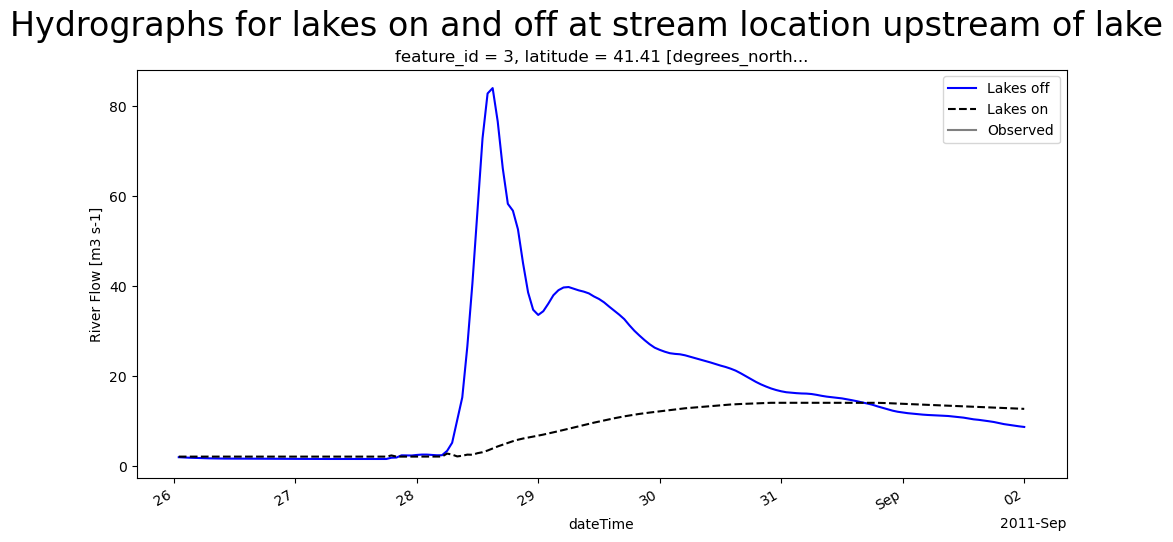

In [26]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs for lakes on and off at stream location upstream of lake',fontsize=24)
chanobs_lakes_off.sel(feature_id = 3).streamflow.plot(label='Lakes off',
                                                        color='blue',
                                                        linestyle='-')
chanobs_baseline.sel(feature_id = 3).streamflow.plot(label='Lakes on',
                                                        color='black',
                                                        linestyle='--')
obs[obs['site_no'] == '01447720'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.legend()
plt.show()

### Discussion
The streamflow values at the stream location upstream of the lake were identical between the simulation with lakes represented and the simulation without lakes represented. This is expected.. and if we did not see this result, it would be an indication of an error somewhere in the process.  
However, at the stream location downstream of a lake we see that streamflow is considerably higher in the simulation without lakes represented. This reflects the expected behavior of the lake attenuating streamflow at the outlet due to storage. 

**Plot the hydrographs at the stream location downstream of the lake**

**NOTE: we changed the `feature_id` to 2 to select a different stream location in the output files and have changed the USGS gauge ID to reflect the downstream gauge location.**

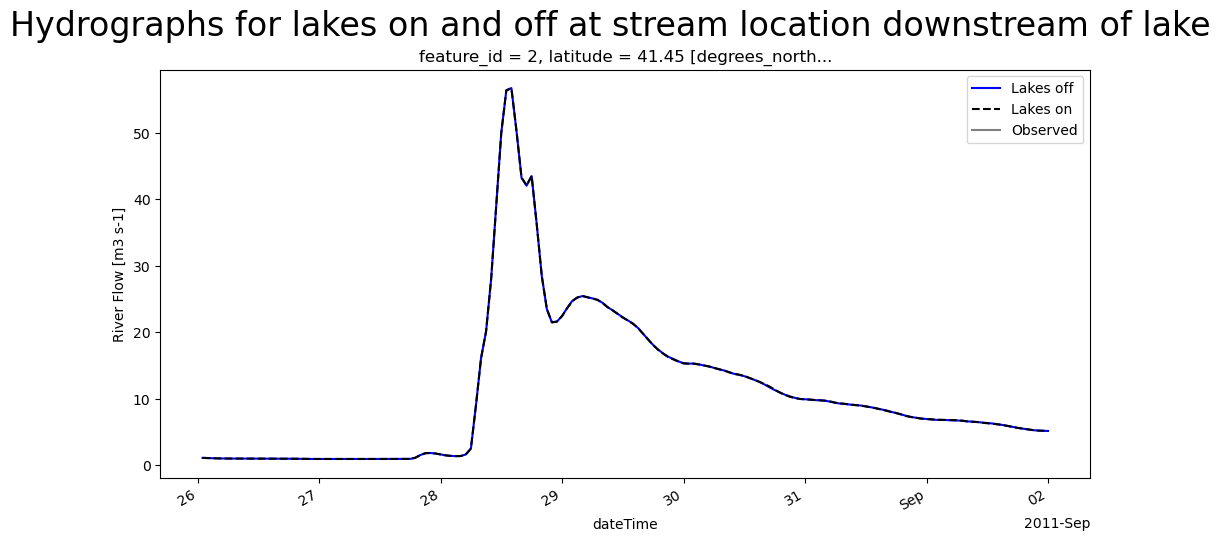

In [27]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs for lakes on and off at stream location downstream of lake',fontsize=24)
chanobs_lakes_off.sel(feature_id = 2).streamflow.plot(label='Lakes off',
                                                        color='blue',
                                                        linestyle='-')
chanobs_baseline.sel(feature_id = 2).streamflow.plot(label='Lakes on',
                                                        color='black',
                                                        linestyle='--')
obs[obs['site_no'] == '01447720'].plot(x='dateTime',
                                         y='streamflow_cms',
                                         ax=axes,
                                         label='Observed',
                                         color='grey')
plt.legend()
plt.show()

### Summary
The 'lakes-off' simulation shows a higher and earlier peak compared with the 'lakes-on' and observed hydrographs. We confirm that this lake serves to attenuate flow during a high event.

# Experiment 2 - Modifying lake parameters in `LAKEPARM.nc`

### Background
The orifice and weir lake parameters populated into LAKEPARM.nc by the GIS pre-processing tools are essentially placeholders for the user to replace with their own data. The accuracy of these parameters can have a significant impact on the storage and thus outflow of the lake. **We highly recommend replacing the default lake parameters with known values!**

### Objective
In this exercise, we will update one of these parameters, the weir length - `WeirL`, with an estimate from observations and explore the impact on the streamflow at the downstream gauge.

### First, let's make a new directory to conduct this experiment.

In [28]:
%%bash
rm -rf ~/wrf-hydro-training/output/lesson6/run_lakeparm_edit
cp -r ~/wrf-hydro-training/output/lesson6/run_gridded_template \
  ~/wrf-hydro-training/output/lesson6/run_lakeparm_edit

### Before modifying anything, let's check the current default value of the WeirL in `LAKEPARM.nc`

In [29]:
%%bash

ncdump -v WeirL ~/wrf-hydro-training/output/lesson6/run_lakeparm_edit/DOMAIN/LAKEPARM.nc | tail -4

data:

 WeirL = 10 ;
}


### Edit the lake parameter file and run the simulation
**Step 1: Edit the `LAKEPARM.nc` file**

NCO (NetCDF Operators, http://nco.sourceforge.net/) is a set of useful utilities to manipulate NetCDF files. We will use the NCO command ncap2 to edit the WeirL variable.

In [30]:
%%bash

ncap2 -s "WeirL=667" ~/wrf-hydro-training/output/lesson6/run_lakeparm_edit/DOMAIN/LAKEPARM.nc \
~/wrf-hydro-training/output/lesson6/run_lakeparm_edit/DOMAIN/LAKEPARM_WeirL_667.nc

**Step 2: Verify that the change was made**

We will check the value of the `WeirL` variable in our new `LAKEPARM_WeirL_667.nc` file against the original `LAKEPARM.nc` file.

`LAKEPARM_WeirL_667.nc`

In [31]:
%%bash
ncdump -v WeirL ~/wrf-hydro-training/output/lesson6/run_lakeparm_edit/DOMAIN/LAKEPARM_WeirL_667.nc | tail -4

data:

 WeirL = 667 ;
}


**Step 3: Edit the *hydro.namelist* to use the new *LAKEPARM_WeirL_667.nc***

We will change the `route_lake_f` option in the [hydro.namelist](../output/lesson6/run_lakeparm_edit/hydro.namelist) to use the edited lakeparm file. 

```
! Specify the lake parameter file (e.g.: "LAKEPARM.nc" for netcdf or "LAKEPARM.TBL" for text).
! Note REQUIRED if lakes are on.
route_lake_f = "./DOMAIN/LAKEPARM_WeirL_667.nc"
```

In [32]:
%%bash
cd ~/wrf-hydro-training/output/lesson6/run_lakeparm_edit
sed -i 's|route_lake_f = "./DOMAIN/LAKEPARM.nc"|route_lake_f = "./DOMAIN/LAKEPARM_WeirL_667.nc"|' hydro.namelist
grep "route_lake_f" hydro.namelist

route_lake_f = "./DOMAIN/LAKEPARM_WeirL_667.nc"


**Step 3: Run the simulation**

In [25]:
%%bash

cd ~/wrf-hydro-training/output/lesson6/run_lakeparm_edit
mpirun -np 2 ./wrf_hydro &> run.log

In [26]:
%%bash

tail -1 ~/wrf-hydro-training/output/lesson6/run_lakeparm_edit/diag_hydro.00000

 The model finished successfully.......


### Results
We will now look at the differences in streamflow between our baseline run with the original WeirL of 10m and our edited WeirL of 677m.

We will use Python and the `xarray` library to load the data and plot hydrographs. For an intro to these tools, please see [Lesson 3](Lesson-3-visualize.ipynb).

**Load the CHANOBS streamflow datasets**

We are going to use the *CHANOBS* files because it will limit the number of grid cells to only those which we have specified have a gage.

In [27]:
chanobs_baseline = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson6/run_gridded_baseline/*CHANOBS*',
                            combine='by_coords')
chanobs_lakeparm_edit = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson6/run_lakeparm_edit/*CHANOBS*',
                            combine='by_coords')
obs = pd.read_csv('/home/docker/wrf-hydro-training/example_case/USGS_obs.csv',dtype=str)
obs['dateTime'] = pd.to_datetime(obs['dateTime'])
obs['streamflow_cms'] = pd.to_numeric(obs['streamflow_cms'])

**Plot the hydrographs**

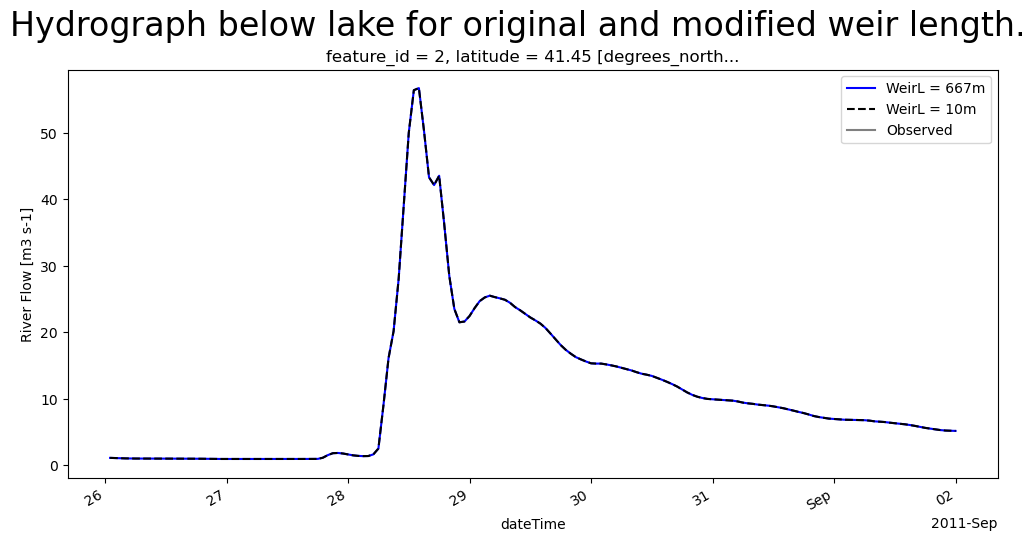

In [28]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrograph below lake for original and modified weir length.',fontsize=24)
chanobs_lakeparm_edit.sel(feature_id = 2).streamflow.plot(label='WeirL = 667m',
                                                        color='blue',
                                                        linestyle='-')
chanobs_baseline.sel(feature_id = 2).streamflow.plot(label='WeirL = 10m',
                                                        color='black',
                                                        linestyle='--')
obs[obs['site_no'] == '01447720'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.legend()
plt.show()

**Compare the result from experiment 1, where the lake was removed.**

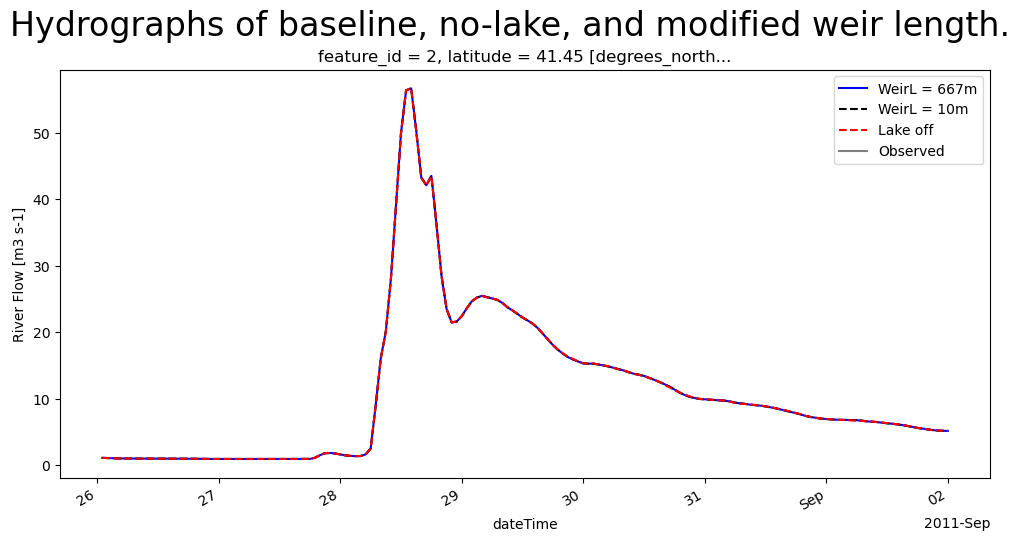

In [29]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs of baseline, no-lake, and modified weir length.',fontsize=24)
chanobs_lakeparm_edit.sel(feature_id = 2).streamflow.plot(label='WeirL = 667m',
                                                        color='blue',
                                                        linestyle='-')
chanobs_baseline.sel(feature_id = 2).streamflow.plot(label='WeirL = 10m',
                                                        color='black',
                                                        linestyle='--')
chanobs_lakes_off.sel(feature_id = 2).streamflow.plot(label='Lake off',
                                                        color='red',
                                                        linestyle='--')
obs[obs['site_no'] == '01447720'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.legend()
plt.show()

### Summary
The increase in weir length causes more water to discharge from the lake earlier than the default. The difference in initial condition for the modified WeirL expt is due to not spinning up with this parameter, and the lake initially discharged to meet its equilibrium. When an abrupt parameter change is made without proper spinup, these artifacts are possible. 

**Load the LAKEOUT files to investigate three lake-related variables: inflow, outflow, and water surface elevation.**

In [30]:
lakeout_baseline = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson6/run_gridded_baseline/*LAKEOUT*',
                            combine='by_coords')
lakeout_weir667 = xr.open_mfdataset('/home/docker/wrf-hydro-training/output/lesson6/run_lakeparm_edit/*LAKEOUT*',
                            combine='by_coords')

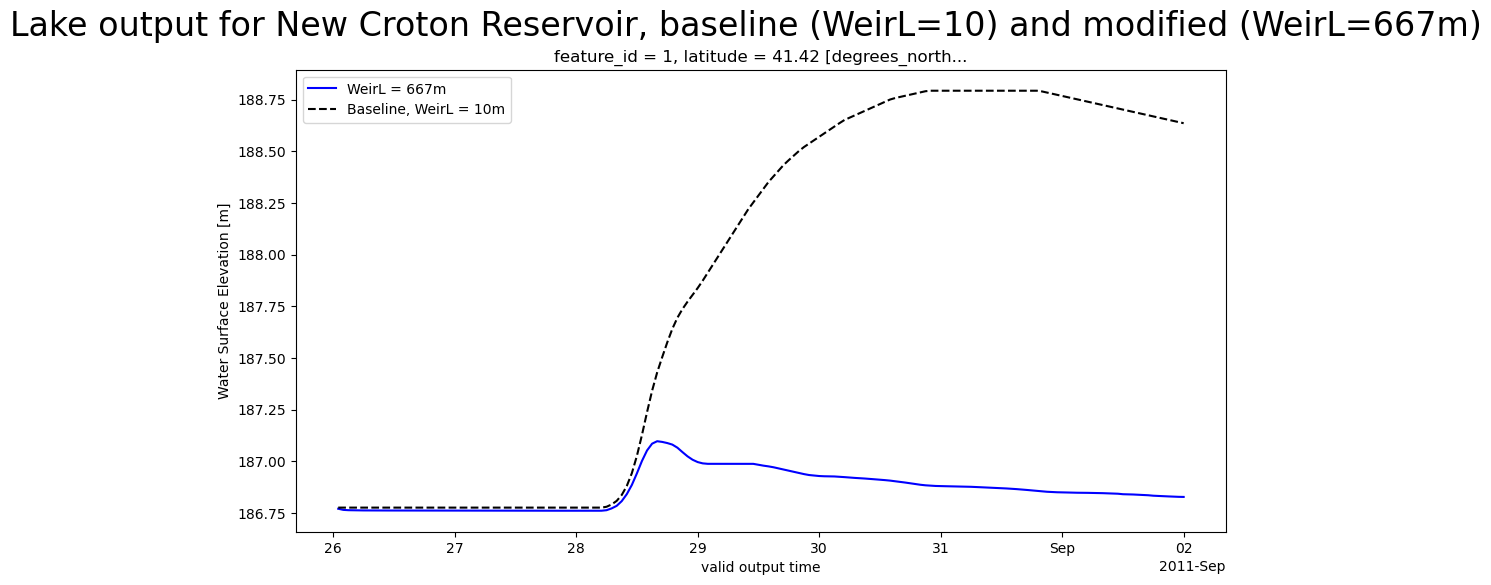

In [31]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Lake output for New Croton Reservoir, baseline (WeirL=10) and modified (WeirL=667m)',fontsize=24)

lakeout_weir667.sel(feature_id = 1).water_sfc_elev.plot(label='WeirL = 667m',
                                                        color='blue',
                                                        linestyle='-')
lakeout_baseline.sel(feature_id = 1).water_sfc_elev.plot(label='Baseline, WeirL = 10m',
                                                        color='black',
                                                        linestyle='--')
plt.legend()
plt.show()

### **On your own experiments**: 
In the above cells, modify the `inflow` variable selection in the plotting function above to `outflow`, then to `water_sfc_elev`.  Feel free to copy and paste the plotting cells so that each of the plots are saved. 

### Discussion
**Streamflow**: We can see that extending the weir length via the `WeirL` parameter has caused the lake to discharge more water out of the weir when the lake level meets (exceeds) the weir elevation.  This has resulted in an increase of streamflow downstream of the lake.

**Lake outputs**: as expected, the inflow into the lake is the same in both simulations (baseline and modified WeirL).  However, we find that the discharge is significantly different, due to more discharge out of the weir.  From the lake level perspective, the baseline simulation shows that the lake continues to fill, and at a slower pace, with the WeirL=10, while the modified experiment with a much longer WeirL keeps the lake level from reaching near its maximum, even during the high inflow condition.

# Next up - Exploring Gridded vs. the NWM configuration
This concludes lesson 6. 

In the [next lesson](Lesson-7-configurations.ipynb), we will explore the differences between the NWM and Gridded configurations.

**IT IS BEST TO EITHER SHUTDOWN THIS LESSON OR CLOSE IT BEFORE PROCEEDING TO THE NEXT LESSON TO AVOID POSSIBLY EXCEEDING ALLOCATED MEMORY. Shutdown the lesson be either closing the browser tab for the lesson or selecting `Kernel -> Shut Down Kernel` in JupyterLab.**

© UCAR 2025